In [ ]:
!sudo pip3 install keras keras-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model

from keras_visualizer import visualizer 

In [ ]:
data_path = "https://raw.githubusercontent.com/MaioranoB/CSGO-Round-Winner-Classification/main/csgo_round_snapshots.csv"
data = pd.read_csv(data_path)
print(data.shape)
data.head()

(122410, 97)


,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


Verificar balanceamento da variável alvo

In [ ]:
TARGET = "T_WINNER"
data[TARGET] = data['round_winner'] == 'T'
data[TARGET].value_counts()
data = data.drop(columns=['round_winner'])
# data['round_winner'].value_counts()

In [ ]:
data['bomb_planted'].value_counts()

False    108726
True      13684
Name: bomb_planted, dtype: int64

In [ ]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


nada tem correlação explícita com T_WINNER

Dropar colunas com valores constantes

In [ ]:
constant_variables = data.columns[data.nunique() == 1]
data.drop(columns = constant_variables, inplace=True)
print(constant_variables)

Index(['ct_weapon_bizon', 'ct_weapon_g3sg1', 't_weapon_m249',
       'ct_weapon_negev', 'ct_weapon_r8revolver', 'ct_weapon_sawedoff'],
      dtype='object')


Dropar mapa de_cache

In [ ]:
data['map'].value_counts()

de_inferno     23811
de_dust2       22144
de_nuke        19025
de_mirage      18576
de_overpass    14081
de_train       13491
de_vertigo     11137
de_cache         145
Name: map, dtype: int64

In [ ]:
de_cache = data['map'] == 'de_cache'
data.drop(data[de_cache].index, inplace=True)
data['map'].value_counts()

de_inferno     23811
de_dust2       22144
de_nuke        19025
de_mirage      18576
de_overpass    14081
de_train       13491
de_vertigo     11137
Name: map, dtype: int64

binarizar MAP

In [ ]:
map_columns = pd.get_dummies(data['map'], prefix = 'map')
data[map_columns.columns] = map_columns
data.drop(columns = "map", inplace=True)
map_columns.head()

,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [ ]:
columns = list(data.columns)
weapon_columns =  [column_name for column_name in columns if 'weapon' in column_name]
grenade_columns = [column_name for column_name in columns if 'grenade' in column_name]
print(f"{len(weapon_columns)} colunas de armas")
print(f"{len(grenade_columns)} colunas de granadas")

62 colunas de armas
12 colunas de granadas


In [ ]:
bad_weapon_columns_ct, bad_grenade_columns_ct = [], []
bad_weapon_columns_t, bad_grenade_columns_t = [], []

# ideia: juntar compras dessas armas diferenciadas em uma unica variavel pra manter essa informação de forma parcial
for col in data[weapon_columns + grenade_columns]:
  if data[col].value_counts()[0] > data.shape[0] * 0.90: # n foram compradas 90% das vezes
    if 'weapon' in col:
      if col.startswith('ct_'):
        bad_weapon_columns_ct.append(col)
      else:
        bad_weapon_columns_t.append(col)
    else:
      if col.startswith('ct_'):
        bad_grenade_columns_ct.append(col)
      else:
        bad_grenade_columns_t.append(col)

print(len(bad_weapon_columns_ct), bad_weapon_columns_ct)
print(len(bad_weapon_columns_t), bad_weapon_columns_t)
print(len(bad_grenade_columns_ct), bad_grenade_columns_ct)
print(len(bad_grenade_columns_t), bad_grenade_columns_t)

18 ['ct_weapon_elite', 'ct_weapon_famas', 'ct_weapon_galilar', 'ct_weapon_glock', 'ct_weapon_m249', 'ct_weapon_m4a1s', 'ct_weapon_mac10', 'ct_weapon_mag7', 'ct_weapon_mp5sd', 'ct_weapon_mp7', 'ct_weapon_nova', 'ct_weapon_p90', 'ct_weapon_scar20', 'ct_weapon_ssg08', 'ct_weapon_ump45', 'ct_weapon_xm1014', 'ct_weapon_fiveseven', 'ct_weapon_tec9']
27 ['t_weapon_aug', 't_weapon_bizon', 't_weapon_cz75auto', 't_weapon_elite', 't_weapon_famas', 't_weapon_g3sg1', 't_weapon_galilar', 't_weapon_m4a1s', 't_weapon_m4a4', 't_weapon_mac10', 't_weapon_mag7', 't_weapon_mp5sd', 't_weapon_mp7', 't_weapon_mp9', 't_weapon_negev', 't_weapon_nova', 't_weapon_p90', 't_weapon_r8revolver', 't_weapon_sawedoff', 't_weapon_scar20', 't_weapon_ssg08', 't_weapon_ump45', 't_weapon_xm1014', 't_weapon_fiveseven', 't_weapon_usps', 't_weapon_p2000', 't_weapon_tec9']
2 ['ct_grenade_molotovgrenade', 'ct_grenade_decoygrenade']
2 ['t_grenade_incendiarygrenade', 't_grenade_decoygrenade']


In [ ]:
data['ct_bad_weapons_bought'] = data[bad_weapon_columns_ct].sum(axis=1)
data['t_bad_weapons_bought'] = data[bad_weapon_columns_t].sum(axis=1)
data['ct_bad_grenades_bought'] = data[bad_grenade_columns_ct].sum(axis=1)
data['t_bad_grenades_bought'] = data[bad_grenade_columns_t].sum(axis=1)

In [ ]:
print(data['ct_bad_weapons_bought'].value_counts()) ## after this, apply minmax scaler!
print(data['t_bad_weapons_bought'].value_counts()) ## after this, apply minmax scaler!

0.0    88235
1.0    23268
2.0     7735
3.0     2446
4.0      497
5.0       84
Name: ct_bad_weapons_bought, dtype: int64
0.0    82285
1.0    21450
2.0     9081
3.0     4502
4.0     2486
5.0     1518
6.0      654
7.0      223
8.0       62
9.0        4
Name: t_bad_weapons_bought, dtype: int64


In [ ]:
print(data['ct_bad_grenades_bought'].value_counts())
print(data['t_bad_grenades_bought'].value_counts())

0.0    113593
1.0      8110
2.0       537
3.0        25
Name: ct_bad_grenades_bought, dtype: int64
0.0    116905
1.0      5154
2.0       201
3.0         5
Name: t_bad_grenades_bought, dtype: int64


In [ ]:
columns_to_drop = bad_weapon_columns_t + bad_weapon_columns_ct + bad_grenade_columns_ct + bad_grenade_columns_t
data = data.drop(columns=columns_to_drop)
data.columns

Index(['time_left', 'ct_score', 't_score', 'bomb_planted', 'ct_health',
       't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets',
       't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
       'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 'ct_weapon_awp',
       't_weapon_awp', 'ct_weapon_cz75auto', 't_weapon_glock',
       'ct_weapon_m4a4', 'ct_weapon_mp9', 'ct_weapon_sg553', 't_weapon_sg553',
       'ct_weapon_deagle', 't_weapon_deagle', 'ct_weapon_usps',
       'ct_weapon_p250', 't_weapon_p250', 'ct_weapon_p2000',
       'ct_grenade_hegrenade', 't_grenade_hegrenade', 'ct_grenade_flashbang',
       't_grenade_flashbang', 'ct_grenade_smokegrenade',
       't_grenade_smokegrenade', 'ct_grenade_incendiarygrenade',
       't_grenade_molotovgrenade', 'T_WINNER', 'map_de_dust2',
       'map_de_inferno', 'map_de_mirage', 'map_de_nuke', 'map_de_overpass',
       'map_de_train', 'map_de_vertigo', 'ct_bad_weapons_bought',
       't_bad_weapons_bo

In [ ]:
## Aplicar minmaxScaler nas coisas

In [ ]:
not_weapon_or_map_columns = list(set(columns) - set(weapon_columns) - set(grenade_columns) - set(map_columns))
not_weapon_or_map_columns

['t_money',
 'ct_helmets',
 'ct_armor',
 'ct_players_alive',
 'bomb_planted',
 't_score',
 't_health',
 'time_left',
 't_players_alive',
 't_armor',
 'ct_score',
 'ct_health',
 't_helmets',
 'T_WINNER',
 'ct_defuse_kits',
 'ct_money']

In [ ]:
not_weapon_or_map_cols_evaluation = [data[col].value_counts() for col in list(not_weapon_or_map_columns)]
not_weapon_or_map_cols_evaluation

[4000.0     2516
 550.0      1939
 600.0      1935
 450.0      1887
 650.0      1679
            ... 
 74700.0       1
 67500.0       1
 63450.0       1
 73650.0       1
 45500.0       1
 Name: t_money, Length: 1399, dtype: int64, 0.0    38501
 5.0    18342
 1.0    18135
 2.0    16251
 4.0    15520
 3.0    15516
 Name: ct_helmets, dtype: int64, 500.0    15871
 0.0      13260
 400.0     9687
 300.0     8128
 200.0     7776
          ...  
 45.0         1
 130.0        1
 43.0         1
 229.0        1
 53.0         1
 Name: ct_armor, Length: 415, dtype: int64, 5.0    81614
 4.0    14495
 3.0    10715
 2.0     8888
 1.0     6552
 0.0        1
 Name: ct_players_alive, dtype: int64, False    108592
 True      13673
 Name: bomb_planted, dtype: int64, 0.0     12150
 3.0      9088
 5.0      8670
 4.0      8630
 1.0      8576
 6.0      8474
 7.0      8008
 8.0      7576
 2.0      7246
 9.0      7202
 10.0     6397
 11.0     6370
 12.0     6090
 13.0     5362
 14.0     5113
 15.0     4743
 18.0

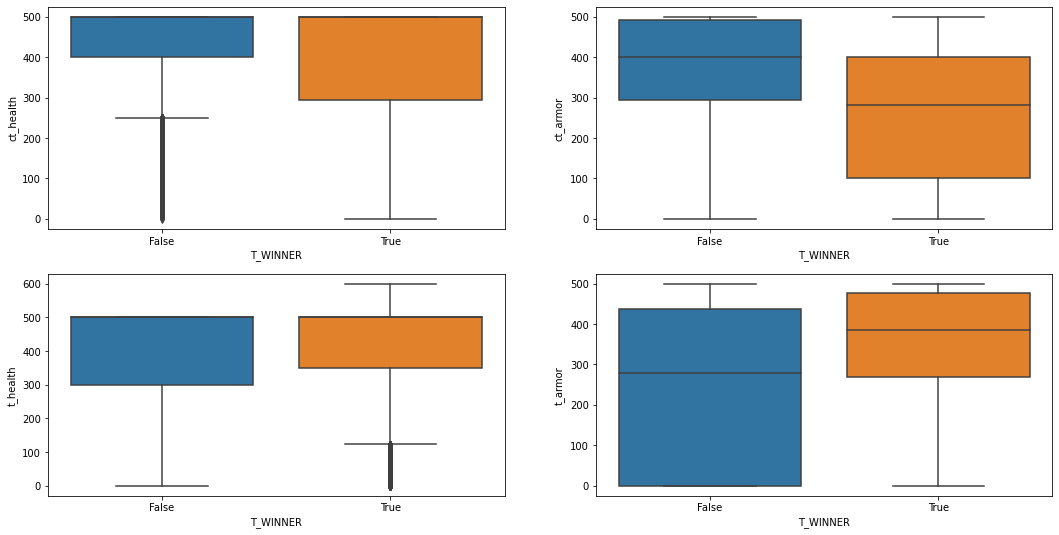

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (18,9))

sns.boxplot(data = data, x = TARGET, y = 'ct_health', ax = ax[0][0])
sns.boxplot(data = data, x = TARGET, y = 'ct_armor', ax = ax[0][1])
sns.boxplot(data = data, x = TARGET, y = 't_health', ax = ax[1][0])
sns.boxplot(data = data, x = TARGET, y = 't_armor', ax = ax[1][1])

plt.show()

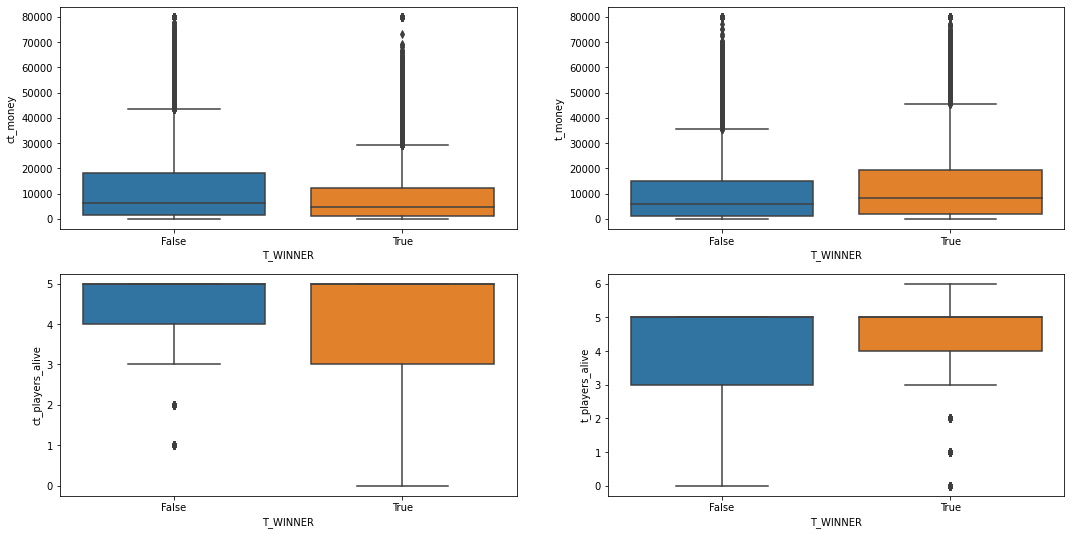

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (18,9))

sns.boxplot(data = data, x = TARGET, y = 'ct_money', ax = ax[0][0])
sns.boxplot(data = data, x = TARGET, y = 't_money', ax = ax[0][1])
sns.boxplot(data = data, x = TARGET, y = 'ct_players_alive', ax = ax[1][0])
sns.boxplot(data = data, x = TARGET, y = 't_players_alive', ax = ax[1][1])

plt.show()

tratar outliers utilizando RobustScaler

In [ ]:
scaler = preprocessing.MinMaxScaler().fit(data)
features = scaler.get_feature_names_out(data.columns)

In [ ]:
scaled_data = scaler.transform(data)

In [ ]:
scaled_df = pd.DataFrame(scaled_data, columns=features)

In [ ]:
scaled_df.T_WINNER.value_counts()

1.0    62364
0.0    59901
Name: T_WINNER, dtype: int64

In [ ]:
corr = scaled_df.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr,vmax=1,vmin=-1,square=True,cmap=plt.cm.RdBu)
plt.show()

In [ ]:
fig, ax = plt.subplots(10,5, figsize = (36,32))
data.plot.hist(subplots=True, ax=ax)

ValueError: ignored

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe01957d310>,
      dtype=object)

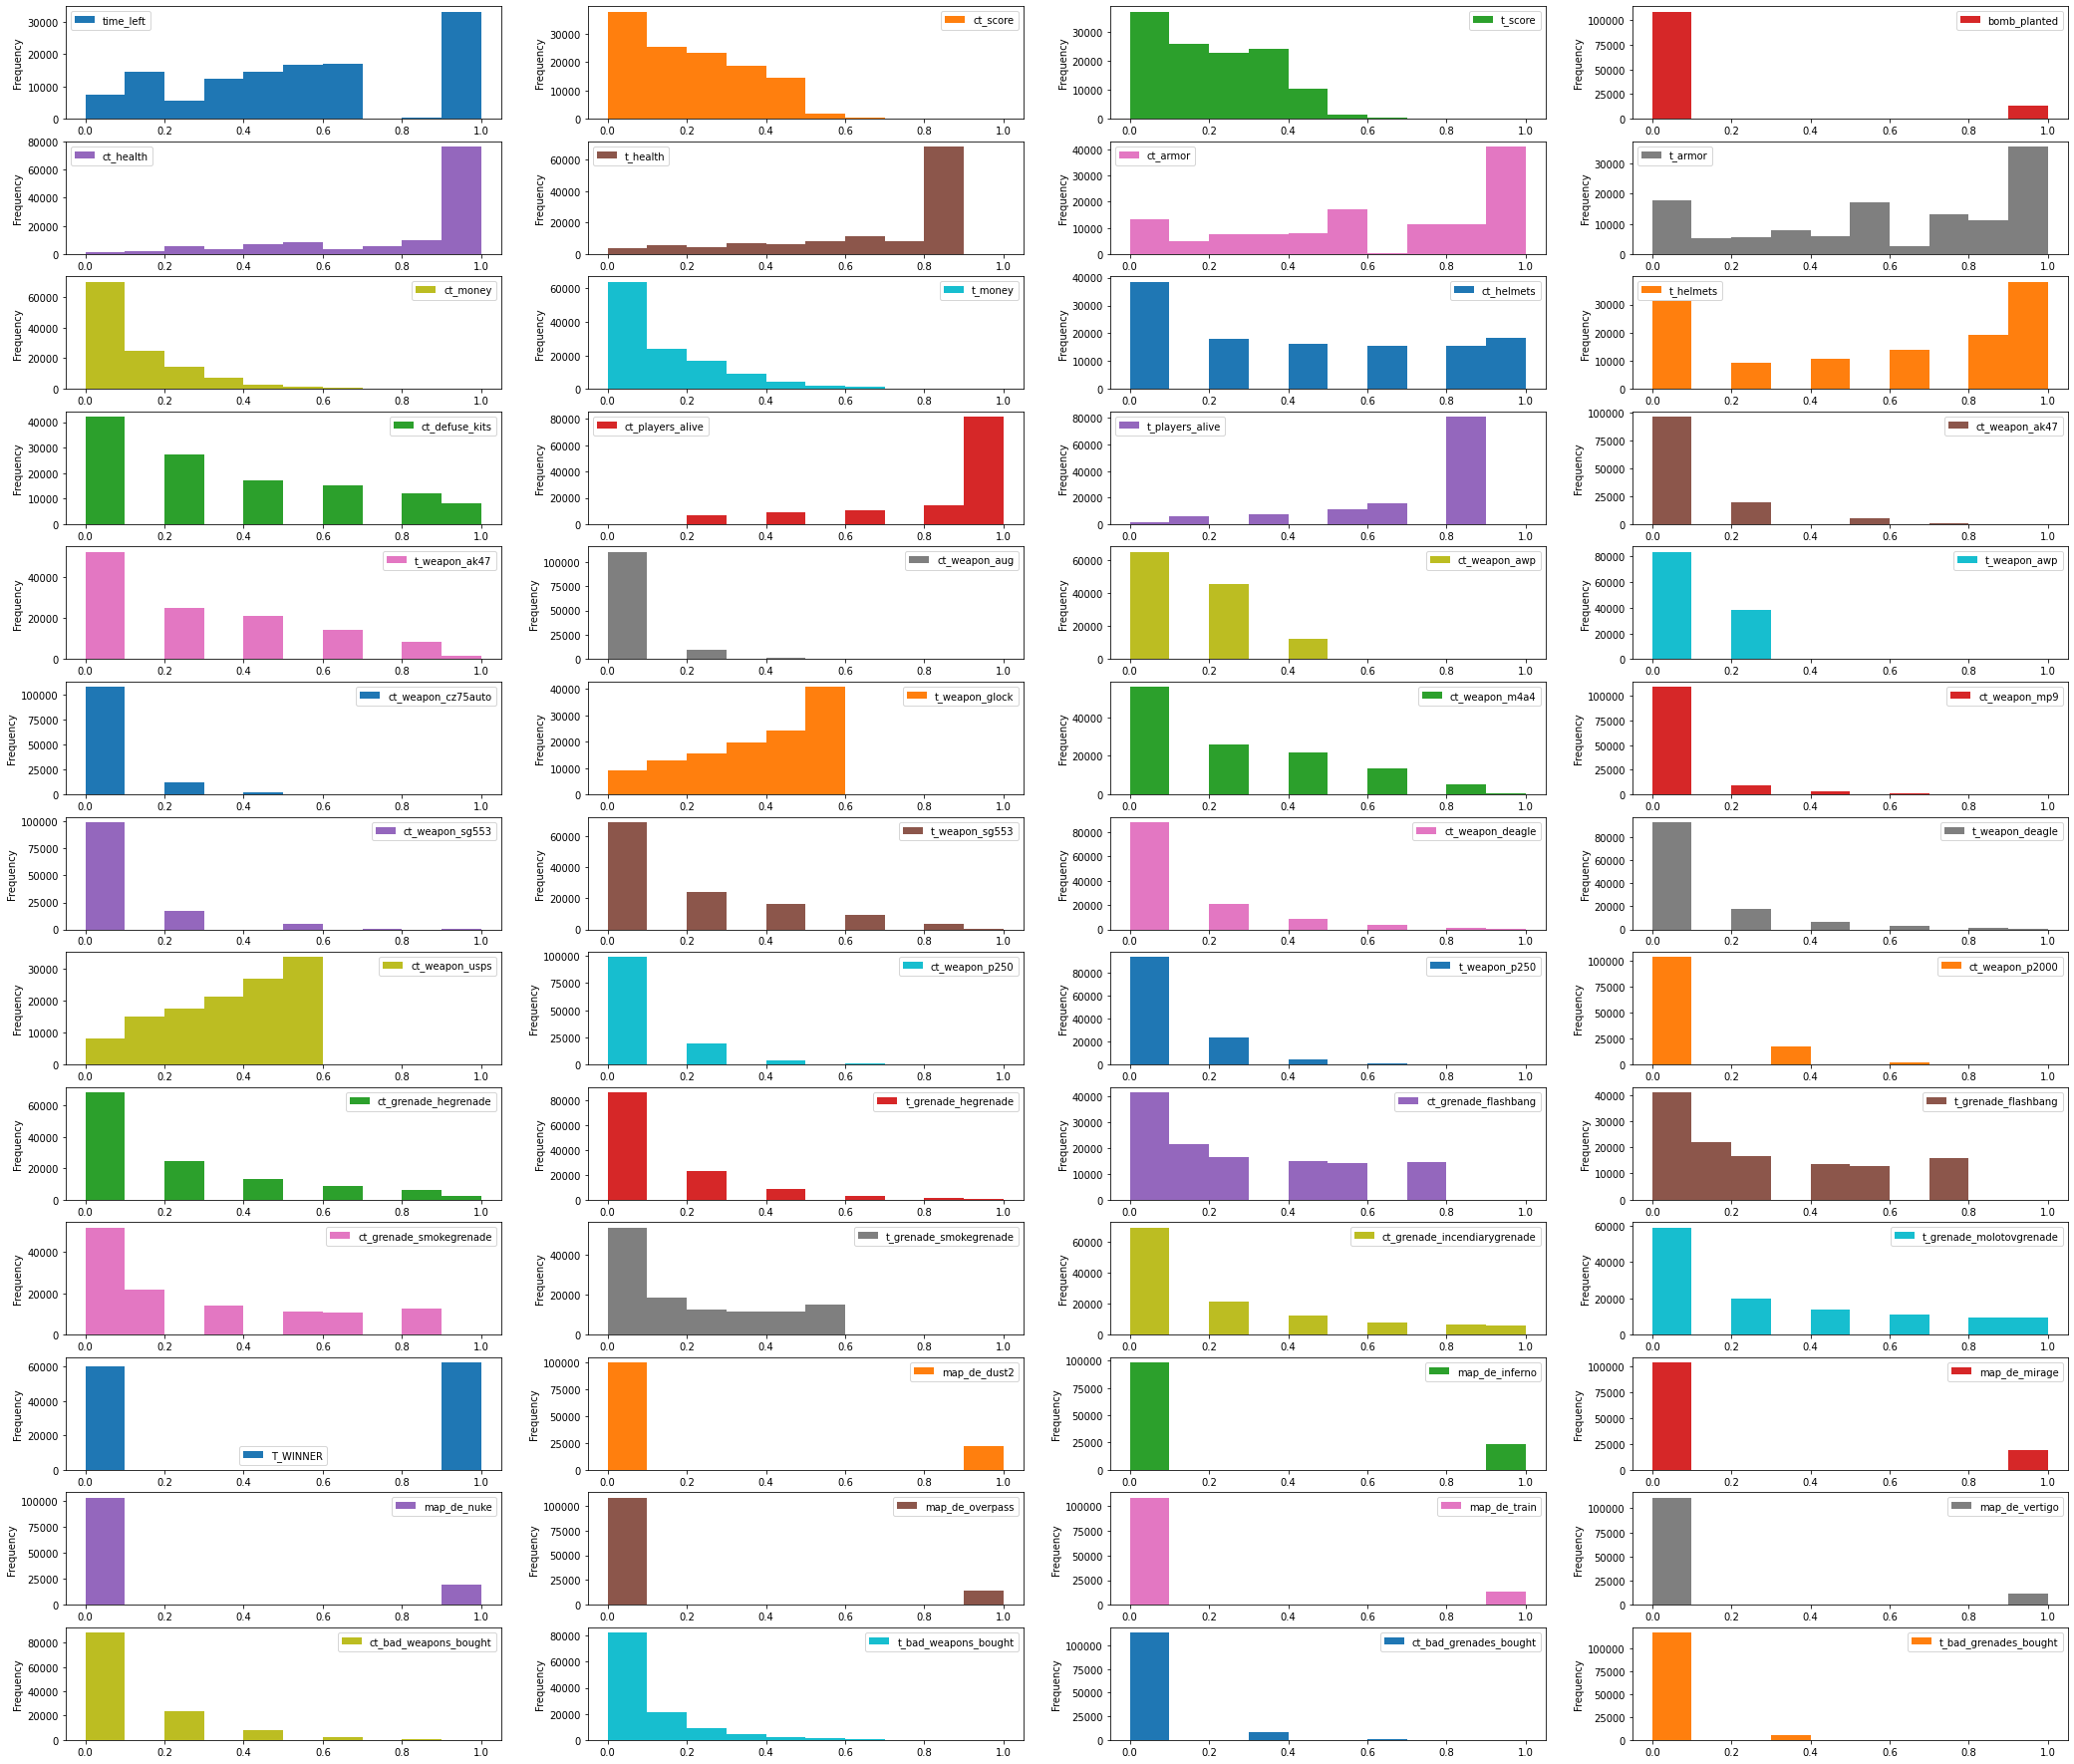

In [ ]:
fig, ax = plt.subplots(13,4, figsize = (36,32))
scaled_df.plot.hist(subplots=True, ax=ax)

Neural Networks

In [ ]:
target_df = pd.DataFrame(scaled_df['T_WINNER'], columns=['T_WINNER'])

In [ ]:
no_target_df = scaled_df.drop(columns=['T_WINNER'])
no_target_df.columns

Index(['time_left', 'ct_score', 't_score', 'bomb_planted', 'ct_health',
       't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets',
       't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
       'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 'ct_weapon_awp',
       't_weapon_awp', 'ct_weapon_cz75auto', 't_weapon_glock',
       'ct_weapon_m4a4', 'ct_weapon_mp9', 'ct_weapon_sg553', 't_weapon_sg553',
       'ct_weapon_deagle', 't_weapon_deagle', 'ct_weapon_usps',
       'ct_weapon_p250', 't_weapon_p250', 'ct_weapon_p2000',
       'ct_grenade_hegrenade', 't_grenade_hegrenade', 'ct_grenade_flashbang',
       't_grenade_flashbang', 'ct_grenade_smokegrenade',
       't_grenade_smokegrenade', 'ct_grenade_incendiarygrenade',
       't_grenade_molotovgrenade', 'map_de_dust2', 'map_de_inferno',
       'map_de_mirage', 'map_de_nuke', 'map_de_overpass', 'map_de_train',
       'map_de_vertigo', 'ct_bad_weapons_bought', 't_bad_weapons_bought',
       'ct_b

Achando a Melhor Arquitetura

In [ ]:
# separar 70/30 para fazer train-test-validation
train_df, super_test_df = train_test_split(scaled_df, test_size=0.3)
test_df, validation_df = train_test_split(super_test_df, test_size=0.5)


# kfold para validar parametros
train_df_no_target = train_df.drop(columns=['T_WINNER'])
train_df_targets = pd.DataFrame(train_df['T_WINNER'], columns=['T_WINNER'])

inputs = np.array(train_df_no_target)
targets = np.array(train_df_targets)

# versão sem dropout: 200-200-200-200 | 94%-83%-84% (50 epochs) - segunda melhor
# versão com dropout 0.1 entre todas 200-200-200-200 | 86%-84%-84% (50 epochs)
# versão com dropout 0.1 entre as do meio apenas 100-200-200-100 | 90%-82%-81% (50 epochs)
# versão com dropout 0.1 entre as do meio apenas 200-200-200-200 | 92%-84%-84% (50 epochs) - tudo relu menos a ultima (sigmoid) - melhor
optimizer = Adam()
model = Sequential()
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(inputs, targets, epochs=100, verbose=True)

Epoch 1/100
2675/2675 [==============================] - 12s 4ms/step - loss: 0.1583 - accuracy: 0.7461
Epoch 2/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1519 - accuracy: 0.7558
Epoch 3/100
2675/2675 [==============================] - 12s 5ms/step - loss: 0.1494 - accuracy: 0.7604
Epoch 4/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1477 - accuracy: 0.7639
Epoch 5/100
2675/2675 [==============================] - 14s 5ms/step - loss: 0.1460 - accuracy: 0.7673
Epoch 6/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1443 - accuracy: 0.7704
Epoch 7/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1421 - accuracy: 0.7745
Epoch 8/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1403 - accuracy: 0.7784
Epoch 9/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1383 - accuracy: 0.7839
Epoch 10/100
2675/2675 [==============================] - 11s 4m

In [ ]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_127 (Dense)           (None, 200)               10400     
                                                                 
 dense_128 (Dense)           (None, 200)               40200     
                                                                 
 dropout_23 (Dropout)        (None, 200)               0         
                                                                 
 dense_129 (Dense)           (None, 200)               40200     
                                                                 
 dense_130 (Dense)           (None, 200)               40200     
                                                                 
 dense_131 (Dense)           (None, 1)                 201       
                                                                 
Total params: 131,201
Trainable params: 131,201
Non-t

In [ ]:
test_df, validation_df = train_test_split(super_test_df, test_size=0.5)

test_df_no_target = test_df.drop(columns=['T_WINNER'])
test_df_targets = pd.DataFrame(test_df['T_WINNER'], columns=['T_WINNER'])

validation_df_no_target = validation_df.drop(columns=['T_WINNER'])
validation_df_targets = pd.DataFrame(validation_df['T_WINNER'], columns=['T_WINNER'])

inputs_test = np.array(test_df_no_target)
targets_test = np.array(test_df_targets)

model.evaluate(inputs_test, targets_test)

574/574 [==============================] - 1s 2ms/step - loss: 0.1221 - accuracy: 0.8508


[0.12212077528238297, 0.850817859172821]

In [ ]:
inputs_validation = np.array(validation_df_no_target)
targets_validation = np.array(validation_df_targets)

model.evaluate(inputs_validation, targets_validation)

574/574 [==============================] - 1s 2ms/step - loss: 0.1256 - accuracy: 0.8449


[0.12562213838100433, 0.8449290990829468]

In [ ]:
no_dropout_model = Sequential()
no_dropout_model.add(Dense(200, activation='relu'))
no_dropout_model.add(Dense(200, activation='relu'))
no_dropout_model.add(Dense(200, activation='relu'))
no_dropout_model.add(Dense(200, activation='relu'))
no_dropout_model.add(Dense(1, activation='sigmoid'))

no_dropout_model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['accuracy'])

history = no_dropout_model.fit(inputs, targets, epochs=100, verbose=True)

Epoch 1/100
2675/2675 [==============================] - 12s 4ms/step - loss: 0.1562 - accuracy: 0.7476
Epoch 2/100
2675/2675 [==============================] - 10s 4ms/step - loss: 0.1513 - accuracy: 0.7557
Epoch 3/100
2675/2675 [==============================] - 10s 4ms/step - loss: 0.1493 - accuracy: 0.7592
Epoch 4/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1478 - accuracy: 0.7630
Epoch 5/100
2675/2675 [==============================] - 13s 5ms/step - loss: 0.1460 - accuracy: 0.7662
Epoch 6/100
2675/2675 [==============================] - 10s 4ms/step - loss: 0.1442 - accuracy: 0.7705
Epoch 7/100
2675/2675 [==============================] - 10s 4ms/step - loss: 0.1426 - accuracy: 0.7737
Epoch 8/100
2675/2675 [==============================] - 10s 4ms/step - loss: 0.1406 - accuracy: 0.7786
Epoch 9/100
2675/2675 [==============================] - 10s 4ms/step - loss: 0.1384 - accuracy: 0.7839
Epoch 10/100
2675/2675 [==============================] - 10s 4m

In [ ]:
no_dropout_model.evaluate(inputs_test, targets_test)

574/574 [==============================] - 2s 3ms/step - loss: 0.1397 - accuracy: 0.8365


[0.13966169953346252, 0.8365321755409241]

In [ ]:
no_dropout_model.evaluate(inputs_validation, targets_validation)

574/574 [==============================] - 2s 3ms/step - loss: 0.1380 - accuracy: 0.8398


[0.13797101378440857, 0.8398036956787109]

In [ ]:
many_dropouts_model = Sequential()
many_dropouts_model.add(Dense(200, activation='relu'))
many_dropouts_model.add(Dropout(0.1))
many_dropouts_model.add(Dense(200, activation='relu'))
many_dropouts_model.add(Dropout(0.1))
many_dropouts_model.add(Dense(200, activation='relu'))
many_dropouts_model.add(Dropout(0.1))
many_dropouts_model.add(Dense(200, activation='relu'))
many_dropouts_model.add(Dense(1, activation='sigmoid'))

many_dropouts_model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['accuracy'])

history = many_dropouts_model.fit(inputs, targets, epochs=100, verbose=True)

Epoch 1/100
2675/2675 [==============================] - 20s 7ms/step - loss: 0.1576 - accuracy: 0.7477
Epoch 2/100
2675/2675 [==============================] - 15s 6ms/step - loss: 0.1522 - accuracy: 0.7552
Epoch 3/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1507 - accuracy: 0.7578
Epoch 4/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1493 - accuracy: 0.7605
Epoch 5/100
2675/2675 [==============================] - 12s 5ms/step - loss: 0.1480 - accuracy: 0.7639
Epoch 6/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1465 - accuracy: 0.7669
Epoch 7/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1453 - accuracy: 0.7692
Epoch 8/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1443 - accuracy: 0.7715
Epoch 9/100
2675/2675 [==============================] - 11s 4ms/step - loss: 0.1428 - accuracy: 0.7742
Epoch 10/100
2675/2675 [==============================] - 12s 4m

In [ ]:
many_dropouts_model.evaluate(inputs_test, targets_test)

574/574 [==============================] - 1s 2ms/step - loss: 0.1179 - accuracy: 0.8349


[0.11786311864852905, 0.8348963856697083]

In [ ]:
many_dropouts_model.evaluate(inputs_validation, targets_validation)

574/574 [==============================] - 3s 5ms/step - loss: 0.1164 - accuracy: 0.8398


[0.11635348200798035, 0.8398036956787109]

In [ ]:
# Melhor modelo: apenas 1 dropout no meio!
# Plotando o modelo mais top

model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


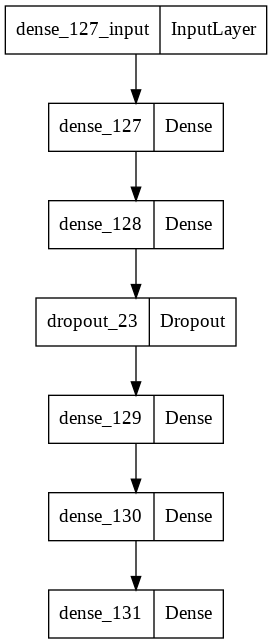

In [ ]:
plot_model(model)

In [ ]:
visualizer(no_dropout_model, format='png', view=True)